In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/benfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/benfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
!pip install bnltk
!pip install bnlp-toolkit==4.0.0.dev4

  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https

In [5]:
!pip install BnLemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00


In [6]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [7]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [8]:
df['data'] = df['headline'] + ' ' + df['content']

In [9]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [10]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [11]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [12]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [13]:
for column in df.columns:
    df[column] = df[column].str.slice(0, 100)

In [14]:
df

,data,class
0,ডিজিটাল নিরাপত্তা আইনে আরও যেসব ধারা যুক্ত করা...,fake
1,দিনের অন্য ম্যাচে মুখোমুখি পাকিস্তান-আফগানিস্ত...,true
2,আফগান-ইয়েমেন ইস্যু নিয়ে কথা বললেন ইমরান সৌদি আ...,true
3,বৃষ্টিপাতের প্রবণতা বাড়তে পারে আগামী ৭২ ঘন্টায়...,true
4,বিচি ঝুলে গেলে কি করবেন? পোতা বা বিচি ঝুলে গেল...,fake
...,...,...
10387,খালেদার অনুপস্থিতিতেই চলবে বিচারকাজ নিজস্ব প্র...,true
10388,রাফায়েল বিমান নিয়ে ফেঁসে যাচ্ছে মোদি সরকার! ফ্...,true
10389,কুষ্টিয়ায় ছেলের বিরুদ্ধে মাকে খুনের অভিযোগ কুষ...,true
10390,এমবিবিএস প্রফেশনাল পরীক্ষায় এগিয়ে আদ্-দ্বীন মে...,true


In [15]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [16]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0       100      4
1       100      4
2       100      4
3       100      4
4       100      4
...     ...    ...
10387   100      4
10388   100      4
10389   100      4
10390   100      4
10391   100      4

[10392 rows x 2 columns]


In [17]:
#Tokenizer
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()

#for Train Set
for i in range(0,df.shape[0]):
    text = bnltk.word_tokenize(df['data'][i])
    df['data'][i] = str(text)

In [18]:
df

,data,class
0,"['ডিজিটাল', 'নিরাপত্তা', 'আইনে', 'আরও', 'যেসব'...",fake
1,"['দিনের', 'অন্য', 'ম্যাচে', 'মুখোমুখি', 'পাকিস...",true
2,"['আফগান-ইয়েমেন', 'ইস্যু', 'নিয়ে', 'কথা', 'বললে...",true
3,"['বৃষ্টিপাতের', 'প্রবণতা', 'বাড়তে', 'পারে', 'আ...",true
4,"['বিচি', 'ঝুলে', 'গেলে', 'কি', 'করবেন', '?', '...",fake
...,...,...
10387,"['খালেদার', 'অনুপস্থিতিতেই', 'চলবে', 'বিচারকাজ...",true
10388,"['রাফায়েল', 'বিমান', 'নিয়ে', 'ফেঁসে', 'যাচ্ছে'...",true
10389,"['কুষ্টিয়ায়', 'ছেলের', 'বিরুদ্ধে', 'মাকে', 'খু...",true
10390,"['এমবিবিএস', 'প্রফেশনাল', 'পরীক্ষায়', 'এগিয়ে',...",true


In [19]:
import BnLemma as lm
bl = lm.Lemmatizer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = bl.lemma(words)



In [20]:
df

,data,class
0,"ডিজিটাল নিরাপত্তা 'আইনে', 'আরও', 'যেসব', ধারা ...",fake
1,"['দিনের', অন্য ম্যাচ মুখোমুখি 'পাকিস্তান-আফগান...",true
2,"['আফগান-ইয়েমেন', 'ইস্যু', 'নিয়ে', কথা 'বললেন',...",true
3,"['বৃষ্টিপাতের', প্রবণতা 'বাড়তে', 'পারে', আগামী...",true
4,"বিচি 'ঝুলে', 'গেলে', 'কি', 'করবেন', '?', 'পোতা...",fake
...,...,...
10387,"খালেদা 'অনুপস্থিতিতেই', 'চলবে', বিচারক নিজস্ব ...",true
10388,"['রাফায়েল', বিমান 'নিয়ে', 'ফেঁসে', 'যাচ্ছে', '...",true
10389,"['কুষ্টিয়ায়', ছেলে বিরুদ্ধ 'মাকে', 'খুনের', অভ...",true
10390,"['এমবিবিএস', 'প্রফেশনাল', পরীক্ষা এগিয়ে 'আদ্-দ...",true


In [21]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [23]:
pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 41.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=e6ceb3f1d1

In [24]:

import ktrain
from ktrain import text
MODEL_NAME = 'xlm-roberta-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [25]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 16
	95percentile : 20
	99percentile : 22


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 16
	95percentile : 20
	99percentile : 22


In [26]:
model = t.get_classifier()

In [27]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [28]:
history = learner.fit_onecycle(2e-5, 10)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
1386/1386 [==============================] - 702s 491ms/step - loss: 0.3461 - accuracy: 0.8655 - val_loss: 0.2316 - val_accuracy: 0.8778
Epoch 2/10
1386/1386 [==============================] - 676s 488ms/step - loss: 0.2306 - accuracy: 0.9125 - val_loss: 0.1818 - val_accuracy: 0.9346
Epoch 3/10
1386/1386 [==============================] - 675s 487ms/step - loss: 0.1830 - accuracy: 0.9293 - val_loss: 0.1968 - val_accuracy: 0.9158
Epoch 4/10
1386/1386 [==============================] - 676s 488ms/step - loss: 0.1426 - accuracy: 0.9442 - val_loss: 0.1956 - val_accuracy: 0.9327
Epoch 5/10
1386/1386 [==============================] - 677s 488ms/step - loss: 0.1311 - accuracy: 0.9508 - val_loss: 0.1308 - val_accuracy: 0.9543
Epoch 6/10
1386/1386 [==============================] - 677s 488ms/step - loss: 0.1085 - accuracy: 0.9621 - val_loss: 0.1255 - val_accuracy: 0.9466
Epoch 7/10
1386/1386 [===========================

In [29]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 13s 154ms/step
              precision    recall  f1-score   support

        fake       0.87      0.78      0.82       254
        true       0.97      0.98      0.98      1825

    accuracy                           0.96      2079
   macro avg       0.92      0.88      0.90      2079
weighted avg       0.96      0.96      0.96      2079



array([[ 199,   55],
       [  30, 1795]])

In [30]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

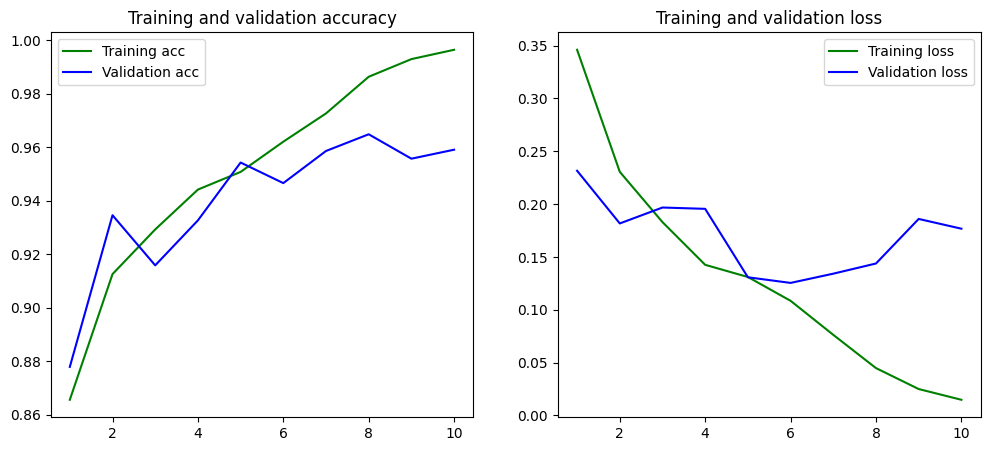

In [31]:
PlotGraph(history)